# Example with random data and a Gaussian dictionary

Implementation of the algorithm detailed in 

<cite data-cite="butucea22"> [1] Modeling infrared spectra : an algorithm for an automatic and simultaneous
analysis, Butucea, Delmas, Dutfoy, Hardy 2021</cite>



Import useful packages

In [1]:
import os, sys 
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
import matplotlib.pyplot as plt
from sliding_frank_wolfe.tools import build_Phi
from sliding_frank_wolfe.dictionary import expo,derivExpo,cauchy,derivCauchy
from sliding_frank_wolfe.SFW_algorithm import SFW
from sliding_frank_wolfe.regularization_parameter import  find_lambda
import numpy as np
import matplotlib.pyplot as plt

# Generate random data


Let $\varphi : \Theta \times \mathbb{R} \rightarrow \mathbb{R}$ be a parametric function.
We define the normalized function $\phi$ on $\Theta \subset \mathbb{R}^2$ taking values in $\mathbb{R}^{T}$ by:
\begin{equation}
\phi(\theta)=\left \|\varphi(\theta)\right \|_2^{-1} \left (\varphi(\theta,t_{1}) , \cdots, \varphi(\theta,t_{T}) \right ).
\end{equation}
We remark that in [1] the normalization of the features is done with a different norm noted $\|\cdot \|_T$.


For any $K\in \mathbb{N}^{*}$ and $\vartheta= (\theta_{1},\ldots,\theta_{K}) \in \Theta^{K}$, we define the multivariate function $\Phi$ on $\Theta^K$ taking its values in $\mathbb{R}^{K\times T}$ by
\begin{equation}
\Phi(\vartheta)= \begin{pmatrix} \phi(\theta_{1})\\
\vdots\\
\phi(\theta_{K})
\end{pmatrix}.
\end{equation}


We generate random data according to the model :
\begin{equation}
Y = B^\star \Phi(\vartheta^\star) + W,
\end{equation}
where $Y \in \mathbb{R}^{n \times T}$ is the matrix of observations ($n$ signals discretized on $T$ points), $B^\star \in \mathbb{R}^{n \times s}$ is a matrix of linear coefficients, $\Phi(\vartheta^\star) \in \mathbb{R}^{s \times T}$ is a matrix corresponding to the discretized peaks, $W \in \mathbb{R}^{n \times T}$ is the noise (the entries are independent centered Gaussian random variables) and $s = Card(S^\star)$.




We take the example of a gaussian parametric function :
\begin{equation}
\varphi_G\colon (\mu,\nu,t)\mapsto {\rm e}^{-\frac{(t-\mu)^{2}}{2\nu^{2}}}\cdot,
\end{equation}
where $\mu$ is a location parameter and $\nu$ is a scaling parameter.


In [2]:
T = 1000                        #number of points in the grid
n = 20                      #number of signals
s = 5                #number of parametric functions in the mixture
noise_level = 0.01            #standard deviation of the gaussian noise

times = np.linspace(-20,20,T)     #grid over which the signals are discretized

scaling_parameters = np.random.uniform(1,5,s)                  #scaling parameter
location_parameters =  np.linspace(times[0]+5,times[-1]-5,s)       #location parameter
np.random.shuffle(location_parameters)
np.random.shuffle(scaling_parameters)

parameters = np.zeros((s,2))  #array of size  s*d containing the parameters of the parametric functions
parameters[:,0] = location_parameters
parameters[:,1] = scaling_parameters

B = np.abs(np.random.uniform(0,10,size=(n,s)))            #linear coefficients
PHI_transpose = build_Phi(times, parameters, s, 0, True,expo)   #build a matrix containing all the parametric functions
BPHI = np.dot(B,np.transpose(PHI_transpose))
W = np.random.normal(0,noise_level,size = BPHI.shape)
Y = BPHI + W

# Plot of the noisy signals

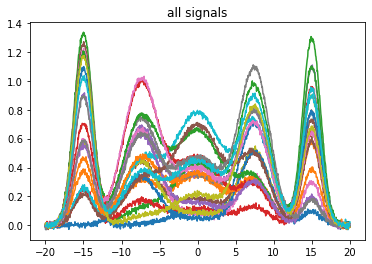

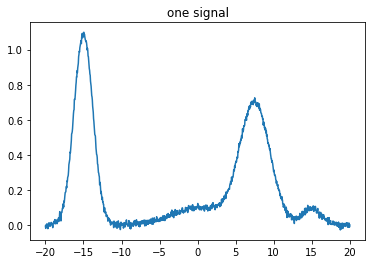

In [3]:

fig = plt.figure()
plt.title('all signals')
plt.plot(times,np.transpose(Y))
plt.show()


fig = plt.figure()
plt.title('one signal')
plt.plot(times,Y[0,:])
plt.show()


# Parameters of the Sliding Frank-Wolfe algorithm

We shall solve the optimization problem
\begin{equation}
(\hat B, \hat \vartheta) \in \underset{\begin{matrix} B\in \mathbb{R}^{n  \times K} \\ \vartheta \in \Theta_{K, T}\left (h\right ) \end{matrix}}{\text{argmin}} \frac{1}{nT}\left \|Y- B\Phi(\vartheta)\right \|_{2}^{2} +\lambda  \| B \|_{1,2},
\end{equation}

where $K$ is an upper bound on $s$ which can be taken arbitralily large.

1) We choose a model $\varphi : \Theta \times \mathbb{R} \rightarrow \mathbb{R}$ to run the SFW algorithm.


ex:  the gaussian parametric function defined by,
\begin{equation}
\varphi_G\colon (\mu,\nu,t)\mapsto {\rm e}^{-\frac{(t-\mu)^{2}}{2\nu^{2}}},
\end{equation}
where $\mu$ is a location parameter and $\nu$ is a scaling parameter.


2) We set upper and lower bounds on the location parameter $\mu$ and the scaling parameter $\nu$.
Typically, peaks that are too thin to appear between two discretization points or wide peaks covering the whole range of observation should not be taken into account in the optimization. In particular, when one uses the Gaussian function to model the peaks, one can take ${2\nu > \Delta_T = \max_j |t_{j+1}-t_j|}$ so that a peak has a significant contribution on the  discretization points. As for an upper bound on $\nu$, one can take for the Gaussian model ${6\nu < t_T -t_1}$ so that a Gaussian function at the center of the observation range puts at least $99\%$ of its mass between $t_1$ and $t_T$.  It is also legitimate to require that the location parameter $\mu$ belongs to the range of observations, that is  ${t_1 \leq \mu \leq t_T}$.

3) We fix the regularization parameter $\lambda \sim \frac{\sigma}{T \sqrt{n}}$ where $\sigma$ denotes the standard deviation of the entries of the matrix $W$.
The order of magnitude  for $\lambda$ proposed in [1] is slighty different due to the different normalization of the features ($\|\cdot\|_T$ instead of $\| \cdot\|_2$ here).


In [4]:
low_location_parameters = np.minimum(times[0],times[-1])
up_location_parameters = np.maximum(times[0],times[-1])
low_scaling_parameters = 0.1
up_scaling_parameters = 10
upper_bounds = [up_location_parameters,up_scaling_parameters] #lower bounds on the parameter
lower_bounds = [low_location_parameters,low_scaling_parameters] #upper bounds on the parameter
size_grids  = [100,100]
phi = expo   #parametric function
deriv_phi = derivExpo #derivative of the parametric function
regularization_parameter =  noise_level  / ( T * np.sqrt(n)) #order of magnitude for the regularization parameter
print('the regularization parameter is fixed to ', regularization_parameter )

the regularization parameter is fixed to  2.2360679774997895e-06


# Display the documentation on the Sliding Frank-Wolfe algorithm


In [5]:
help(SFW)

Help on function SFW in module sliding_frank_wolfe.SFW_algorithm:

SFW(data, times, reg, lower_bounds, upper_bounds, func, deriv_func, threshold=0.0001, merging_threshold=0.0001, rank='full', size_grids=None, normalized=True, epsilon=0.0001, max_iter=100, size_mesh=1000, positive=False)
    Run the sliding Frank-Wolfe algorithm on a set of n signals disctretized on p points. The signals are approximated by
    linear combinations of parametric functions "func". The parametric functions are parametrized by a parameter of dimension d.
    
    Parameters
    ----------
    data : array, shape (p,n)
        array of n signals distretized on p points.
    
    times : array, shape(p,)
        array of size p corresponding to the points over which the signals are discretized.
    
    reg : float
        regularization parameter of the optimization problem.
    
    lower_bounds : array, shape(d,)
        lower_bounds on the parameters of the parametric functions. The k-th coordinate of the

# Run the Sliding Frank-Wolfe algorithm

During the SFW procedure, we shall merge the Gaussian peaks that are too close, that is when for two peaks paremetrized by $\theta_\ell$ and $\theta_k$, we have

\begin{equation}
\mathcal{K}_T(\theta_\ell, \theta_k):=\left |\langle \phi(\theta_{\ell}), \phi(\theta_{k}) \rangle\right |> h.
\end{equation}
or equivalently (because the features are normalized and positive)
\begin{equation}
\|\phi(\theta_k) - \phi(\theta_\ell) \|_2 < \tau,
\end{equation}
where $\tau = \sqrt{2 - 2 h}$ is a merging threshold.




In [6]:

merging_threshold = 0 
K=50 


res_optim = SFW(np.transpose(Y), times, regularization_parameter, lower_bounds, upper_bounds, phi, deriv_phi,merging_threshold = merging_threshold, max_iter = K, positive = False)


Bopt = res_optim.linear_coefficients
parameters_opt = res_optim.dictionary_parameters
coeff  = res_optim.history_norms_linear_parameters
ite = res_optim.iterations
print('the matrix of linear coefficients if of full rank:', res_optim.is_full_rank )
print('the rank is:',res_optim.rank)
print('the sparsity is:', res_optim.sparsity )

kopt = parameters_opt.shape[0]
PHIopt_T = build_Phi(times, parameters_opt, kopt, 0, normalized = True,func=phi)
BPHIopt = np.dot(Bopt,np.transpose(PHIopt_T))


the matrix of linear coefficients if of full rank: True
the rank is: 11
the sparsity is: 11


It may be necessary to re-run the algorithm with a higher merging threshold if the matrix $\Phi(\hat \vartheta))$ is not of full rank.

In [7]:
print('the rank of the matrix PHI is :',np.linalg.matrix_rank(PHIopt_T))
if np.linalg.matrix_rank(PHIopt_T) == kopt:
    print('the matrix is of full rank')
else:
    print('the matrix is not of full rank')


the rank of the matrix PHI is : 11
the matrix is of full rank


# plot denoised data

We shall represent  the approximations of the $n$ signals disretized on $T$ points found by the SFW algorithm : $\hat B \Phi(\hat \vartheta)) \in \mathbb{R}^{n \times T}$.

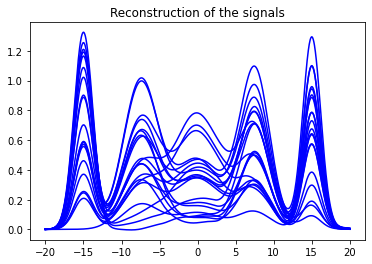

In [8]:
plt.figure()
plt.title('Reconstruction of the signals')
plt.plot(times,np.transpose(BPHIopt),color='b')
plt.show()

# plot original data without noise

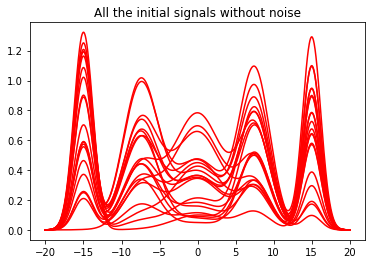

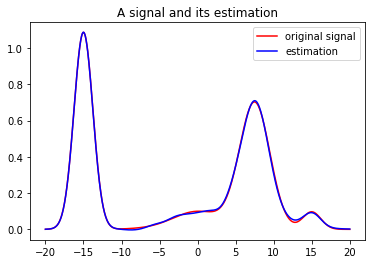

In [9]:
plt.figure()
plt.title('All the initial signals without noise')
plt.plot(times,np.transpose(BPHI),color='r')
plt.show()

plt.figure()
plt.title('A signal and its estimation')
plt.plot(times,BPHI[0,:],color='r', label = 'original signal')
plt.plot(times,BPHIopt[0,:] ,color='b', label = 'estimation')
plt.legend()
plt.show()


# Value of the objective function after each SFW iteration

The sliding Frank-Wolfe algorithm produces at the i-th iteration estimators $(B^{(i)}, \vartheta^{(i)})$.
We shall represent 
\begin{equation}
\frac{1}{nT}\left \|Y- B^{(i)}\Phi(\vartheta^{(i)})\right \|_{2}^{2} +\lambda  \| B^{(i)} \|_{1,2},
\end{equation}
with respect to $i$.

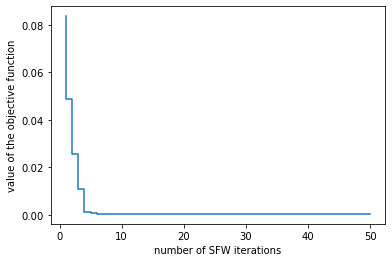

In [10]:
plt.figure()
plt.ylabel('value of the objective function')
plt.xlabel('number of SFW iterations')
plt.step(np.arange(1,len(ite) +  1),ite)
plt.show()


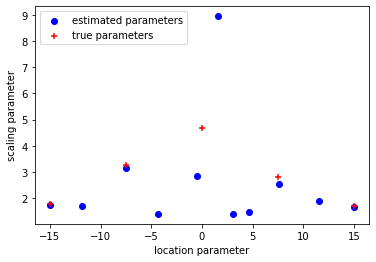

In [11]:
plt.figure(5)
plt.scatter(parameters_opt[:,0],parameters_opt[:,1], label = "estimated parameters", color = 'b')
plt.scatter(parameters[:,0],parameters[:,1], label = "true parameters", color = 'r', marker = '+')
plt.xlabel('location parameter')
plt.ylabel('scaling parameter')
plt.legend()
plt.show()

We  sort and represent $(\| \hat B_{i,.}\|_2, i \in \{1,\cdots,K\})$.

0.2748890297110486


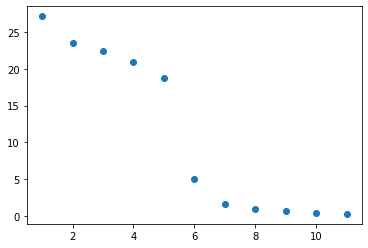

In [12]:
norm_B = np.linalg.norm(Bopt,ord=2,axis=0)
L = len(norm_B)
sorted_index = np.flip(np.argsort(norm_B))
print(norm_B[sorted_index[-1]])
plt.figure()
X = np.arange(1,L+1)
plt.scatter(X,np.flip(np.sort(norm_B)))
plt.show()


# Choosing the best value for the regularization parameter

We shall solve for different values of the regularization parameter $\lambda$ the following  optimization problem using the SFW algorithm :
\begin{equation}
(\hat B, \hat \vartheta) \in  \underset{\begin{matrix} B\in \mathbb{R}^{n  \times K} \\ \vartheta \in \Theta_{K, T}\left (h\right ) \end{matrix}}{\text{argmin}} \frac{1}{nT}\left \|Y- B\Phi(\vartheta)\right \|_{2}^{2} +\lambda  \| B \|_{1,2},
\end{equation}

The regularization parameter $\lambda$ must be tuned. Intuitively,  choosing a large value for $\lambda$ will make the term of penalization in  the problem above preponderant and set a lot of  entries of the matrix $\hat B$ to zero. In this case, one expects the solutions to underestimate the number of peaks in the model. On the contrary, a small value for $\lambda$ will  set very few entries of the matrix $\hat{B}$ to zero and will lead to overestimate the number of peaks in the model.

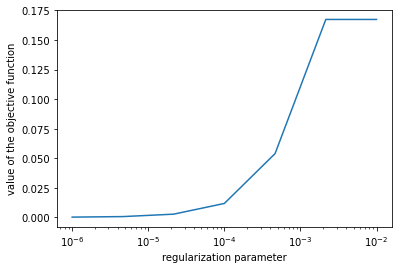

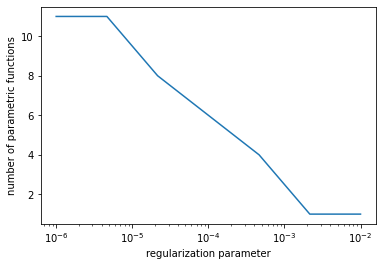

In [13]:
range_lbda =  np.logspace(-6, -2, 7)
MSE, MSE_penalized, number_of_peaks = find_lambda(np.transpose(Y), times, range_lbda, lower_bounds, upper_bounds, func=phi, deriv_func = deriv_phi,max_iter=50)

#value of the objective function with respect to the regularization parameter
plt.figure()
plt.plot(range_lbda, MSE_penalized)
plt.xscale('log')
plt.ylabel('value of the objective function')
plt.xlabel('regularization parameter')
plt.show()

#number of parametric function used with respect to the regularization parameter
plt.figure()
plt.plot(range_lbda, number_of_peaks)
plt.xscale('log')
plt.ylabel('number of parametric functions')
plt.xlabel('regularization parameter')
plt.show()
